<a href="https://colab.research.google.com/github/Harsh-Gehlot/StockPricePredictionWithLSTM/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**1. Import and Install Dependencies**

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 805 kB/s 
     |████████████████████████████████| 6.4 MB 55.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import math # Mathematical functions
from datetime import date, timedelta, datetime # Date Functions

import numpy as np # Fundamental package for scientific computing with Python

import pandas as pd # Additional functions for analysing and manipulating data
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates

import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization

import tensorflow as tf
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
from keras.activations import relu

from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 


**Download dataset**

In [3]:
import yfinance as yf 

start_date = '2020-02-27'
end_date = '2022-03-01'
# date_today = today.strftime("%Y-%m-%d")
symbol = 'RELIANCE.NS'

df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-27,1374.966675,1380.712280,1356.145142,1373.233154,1363.709229,11562875
2020-02-28,1342.177490,1344.257812,1312.558228,1316.173950,1307.045776,18144221
2020-03-02,1342.375610,1356.145142,1288.882690,1303.791382,1294.749023,13614473
2020-03-03,1317.214111,1341.186890,1309.586426,1330.240601,1321.014893,12644541
2020-03-04,1339.304688,1341.087769,1295.618774,1327.120239,1317.916016,10201574


In [5]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-22,2352.899902,2395.899902,2347.149902,2389.000000,2389.000000,6227901
2022-02-23,2401.100098,2406.550049,2368.000000,2374.050049,2374.050049,3373615
2022-02-24,2305.000000,2339.899902,2243.399902,2255.750000,2255.750000,11466725
2022-02-25,2280.100098,2307.949951,2276.250000,2283.949951,2283.949951,6724094
2022-02-28,2243.000000,2367.350098,2243.000000,2359.550049,2359.550049,9828768


In [6]:
df_plot = df.copy()
df_plot = df_plot.reset_index()  # reset index from dates to row numbers
df_plot.drop(["Date"],axis=1)

,Open,High,Low,Close,Adj Close,Volume
0,1374.966675,1380.712280,1356.145142,1373.233154,1363.709229,11562875
1,1342.177490,1344.257812,1312.558228,1316.173950,1307.045776,18144221
2,1342.375610,1356.145142,1288.882690,1303.791382,1294.749023,13614473
3,1317.214111,1341.186890,1309.586426,1330.240601,1321.014893,12644541
4,1339.304688,1341.087769,1295.618774,1327.120239,1317.916016,10201574
...,...,...,...,...,...,...
494,2352.899902,2395.899902,2347.149902,2389.000000,2389.000000,6227901
495,2401.100098,2406.550049,2368.000000,2374.050049,2374.050049,3373615
496,2305.000000,2339.899902,2243.399902,2255.750000,2255.750000,11466725
497,2280.100098,2307.949951,2276.250000,2283.949951,2283.949951,6724094


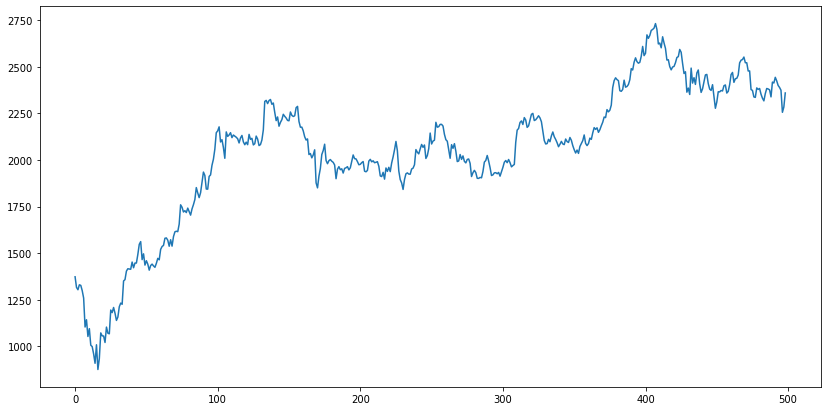

In [7]:
plt.figure(figsize=(14,7))
plt.plot(df_plot.Close)


**Rolling Averages**

In [8]:
MA100 = df_plot.Close.rolling(100).mean()
MA50 = df_plot.Close.rolling(50).mean()

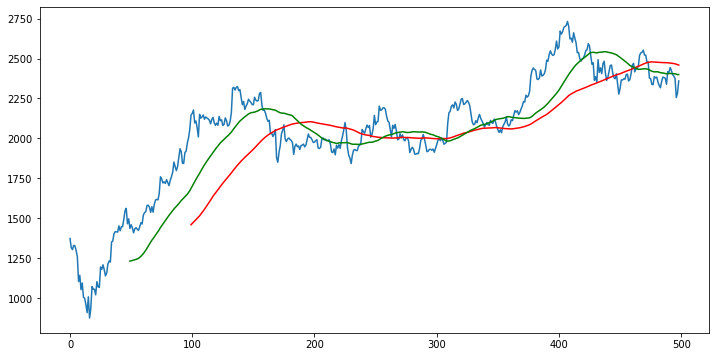

In [9]:
plt.figure(figsize=(12,6))
plt.plot(df_plot.Close)
plt.plot(MA100, 'r')
plt.plot(MA50, 'g')

###**3. Data Preprocessing**

In [10]:
train_df = df.sort_values(by=['Date']).copy()

date_index = train_df.index
# print(date_index)
train_df = train_df.reset_index(drop=True).copy()

FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume']

data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

data_filtered_ext.tail()

,High,Low,Open,Close,Volume,Prediction
494,2395.899902,2347.149902,2352.899902,2389.000000,6227901,2389.000000
495,2406.550049,2368.000000,2401.100098,2374.050049,3373615,2374.050049
496,2339.899902,2243.399902,2305.000000,2255.750000,11466725,2255.750000
497,2307.949951,2276.250000,2280.100098,2283.949951,6724094,2283.949951
498,2367.350098,2243.000000,2243.000000,2359.550049,9828768,2359.550049


In [11]:
train_df.head()

,Open,High,Low,Close,Adj Close,Volume
0,1374.966675,1380.712280,1356.145142,1373.233154,1363.709229,11562875
1,1342.177490,1344.257812,1312.558228,1316.173950,1307.045776,18144221
2,1342.375610,1356.145142,1288.882690,1303.791382,1294.749023,13614473
3,1317.214111,1341.186890,1309.586426,1330.240601,1321.014893,12644541
4,1339.304688,1341.087769,1295.618774,1327.120239,1317.916016,10201574


In [12]:
nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
# print("Before reshaping ", np_data_unscaled.shape)

np_data = np.reshape(np_data_unscaled, (nrows, -1))

print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(499, 5)


In [13]:
sequence_length = 50

index_Close = data.columns.get_loc("Close")

train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value

# print(x_train[1][sequence_length-1][index_Close])
# print(y_train[0])

(350, 50, 5) (350,)
(99, 50, 5) (99,)


### **4. Training** 

**Create Model**

In [25]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5 ,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))



250 50 5


**Compile Model**

In [26]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

**Summary**

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 250)           256000    
                                                                 
 lstm_3 (LSTM)               (None, 250)               501000    
                                                                 
 dense_2 (Dense)             (None, 5)                 1255      
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 758,261
Trainable params: 758,261
Non-trainable params: 0
_________________________________________________________________


**Training Model**

In [28]:
# Training the model
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stop]
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/50
22/22 [==============================] - 4s 45ms/step - loss: 0.1251 - val_loss: 0.0176
Epoch 2/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0515 - val_loss: 0.0152
Epoch 3/50
22/22 [==============================] - 0s 10ms/step - loss: 0.0425 - val_loss: 0.0178
Epoch 4/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0452 - val_loss: 0.0081
Epoch 5/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0340 - val_loss: 0.0101
Epoch 6/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0315 - val_loss: 0.0153
Epoch 7/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0298 - val_loss: 0.0222
Epoch 8/50
22/22 [==============================] - 0s 10ms/step - loss: 0.0257 - val_loss: 0.0078
Epoch 9/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0269 - val_loss: 0.0114
Epoch 10/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0291 - val_loss: 0.0057
Epoch 11/

### **5. Prediction and Visualization**

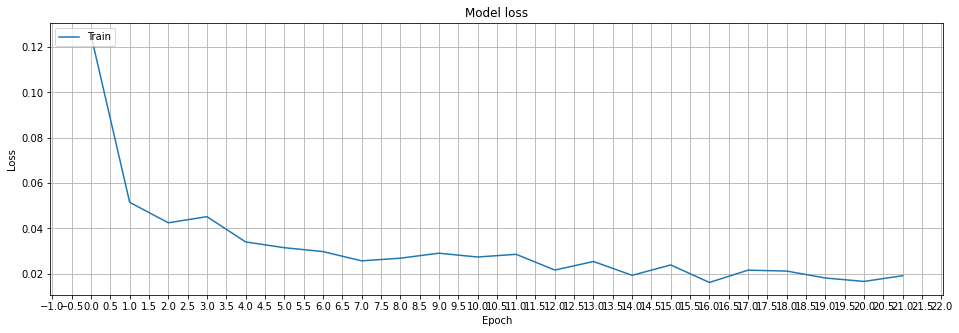

In [30]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
# sns.lineplot(data=history.history["val_loss"])
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [31]:
y_pred_scaled = model.predict(x_test)

In [ ]:
y_pred_scaled

In [33]:
# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 51.24
Mean Absolute Percentage Error (MAPE): 2.07 %
Median Absolute Percentage Error (MDAPE): 1.81 %


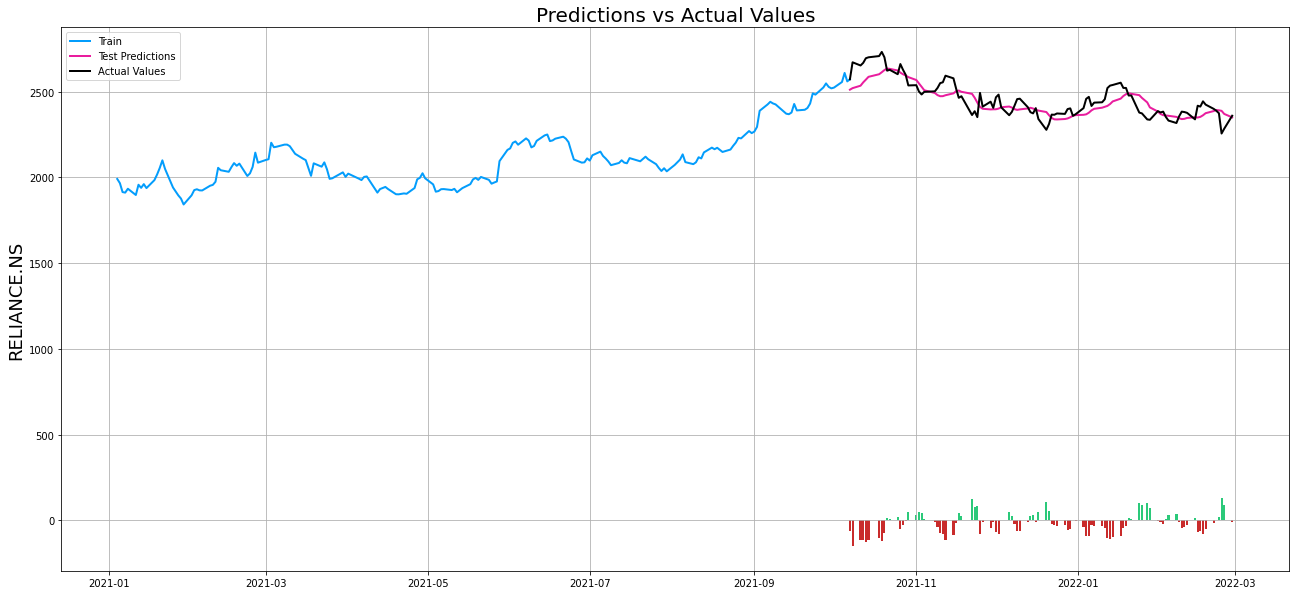

In [34]:
display_start_date = "2021-01-01"

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel(symbol, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()